<a href="https://colab.research.google.com/github/pjxl/utils/blob/main/psm_module_runbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Intro
This is a rudimentary runbook that illustrates how to use the Python propensity score ,atching utilities in my `psm` submodule. (Python code [here](https://github.com/pjxl/utils/blob/main/psm.py).)

In [ ]:
# Clone the utils repo
!git clone https://github.com/pjxl/utils

In [21]:
import pandas as pd
import utils.psm as psm

Import and inspect the dataset for demo:

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/pjxl/utils/main/datasets/lalonde.csv', index_col=0)
df.head()

,treat,age,educ,race,married,nodegree,re74,re75,re78
NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,black,0,1,0.0,0.0,289.7899


Details about the dataset, from its [codebook](http://sekhon.berkeley.edu/matching/lalonde.html) in R:

---

*Dataset used by Dehejia and Wahba (1999) to evaluate propensity score matching.*

- `age` : *age in years.*
- `educ` : *years of schooling.*
- `black` : *indicator variable for Black subject.*
- `hisp` : *indicator variable for Hispanic subject.*
- `married` : *indicator variable for martial status.*
- `nodegr` : *indicator variable for high school diploma.*
- `re74` : *real earnings in 1974.*
- `re75` : *real earnings in 1975.*
- `re78` : *real earnings in 1978.*
- `u74` : *indicator variable for earnings in 1974 being zero.*
- `u75` : *indicator variable for earnings in 1975 being zero.*
- `treat` : *an indicator variable for treatment status.*

# Generating Propensity Scores

Our first step is to instantiate a PropensityScore object, which at its simplest just involves passing in `df` and an R-style `formula` specifying how to fit the GLM model that will be used to generate propensity scores:

In [4]:
ps = psm.PropensityScore(df, 'treat ~ age + educ + race + married + nodegree + re74 + re75')

The `.data` property contains the original data in `df` (during instantiation it's re-indexed though):

In [5]:
ps.data.head()

,treat,age,educ,race,married,nodegree,re74,re75,re78
0,1,37,11,black,1,1,0.0,0.0,9930.0460
1,1,22,9,hispan,0,1,0.0,0.0,3595.8940
2,1,30,12,black,0,0,0.0,0.0,24909.4500
3,1,27,11,black,0,1,0.0,0.0,7506.1460
4,1,33,8,black,0,1,0.0,0.0,289.7899


The DataFrame returned by `.balance` shows the pre-matching balance across the specified covariates:

In [6]:
ps.balance

,Covariate,Mean (Control),Mean (Treatment),Abs. Std. Mean Diff
0,race[T.hispan],0.142191,0.059459,0.277398
1,race[T.white],0.655012,0.097297,1.407988
2,age,28.030303,25.816216,0.241707
3,educ,10.235431,10.345946,0.044720
4,married,0.512821,0.189189,0.720755
5,nodegree,0.596737,0.708108,0.235491
6,re74,5619.236506,2095.573689,0.595293
7,re75,2466.484443,1532.055314,0.286830


A `pandas.Series` of the generated propensity scores is stored in `.scores` (indices are aligned to those of `.data`):

In [7]:
ps.scores

0      0.638770
1      0.224634
2      0.678244
3      0.776324
4      0.701639
         ...   
609    0.123144
610    0.034560
611    0.183351
612    0.383032
613    0.089712
Length: 614, dtype: float64

The `statsmodels` GLM fit used to generate the propensity scores can be retrieved using the `.score_fit` property:

In [8]:
print(ps.score_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  treat   No. Observations:                  614
Model:                            GLM   Df Residuals:                      605
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -243.92
Date:                Fri, 15 Apr 2022   Deviance:                       487.84
Time:                        20:36:15   Pearson chi2:                     556.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.6633      0.971     -1.

By default, scores are generated using logistic regression (`link='logit'`), but a probit model can be specified instead:

In [9]:
ps2 = psm.PropensityScore(df, 'treat ~ age + educ + race + married + nodegree + re74 + re75', link='probit')
print(ps2.score_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  treat   No. Observations:                  614
Model:                            GLM   Df Residuals:                      605
Model Family:                Binomial   Df Model:                            8
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -243.06
Date:                Fri, 15 Apr 2022   Deviance:                       486.13
Time:                        20:36:15   Pearson chi2:                     564.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8934      0.559     -1.

# Matching Observations

We can generate matches based on our propensity scores by calling the method `ps.get_matches_nearest()`, which conducts nearest-neighbor matching. It returns an instance of a `Match` object.

In [35]:
match = ps.get_matches_nearest()

Our `match` object has a `.data` property, which contains the _post-matching_ dataset – i.e., the original dataset, minus the observations that were discarded during matching:

In [11]:
match.data.head()

,treat,age,educ,race,married,nodegree,re74,re75,re78
177,1,33,11,black,0,1,0.000,7867.9160,6281.4330
302,0,20,11,black,0,1,0.000,3480.3870,5495.6650
94,1,44,11,black,0,1,0.000,0.0000,0.0000
410,0,39,10,black,0,1,844.444,889.7903,701.9201
175,1,28,11,black,0,1,1929.029,6871.8560,0.0000


In [12]:
print('Pre-matching dataset dimensions:', ps.data.shape)
print('Post-matching dataset dimensions:', match.data.shape)

Pre-matching dataset dimensions: (614, 9)
Post-matching dataset dimensions: (370, 9)


`.get_matches_nearest()`'s default behavior is to loop through each treatment observation – in descending order of propensity scores – and find the control observation with the nearest propensity score value. This is done without replacement: after a given control observation is selected as a match, it is removed from the pool of future match candidates. Once the list of treatment observations has been exhausted, the matching procedure ends.

Given the original shape of our data, this effectively means that we're down-sampling the control group:

In [13]:
print('Pre-matching group sizes:')
ps.data['treat'].value_counts()

Pre-matching group sizes:


0    429
1    185
Name: treat, dtype: int64

In [14]:
print('Post-matching group sizes:')
match.data['treat'].value_counts()

Post-matching group sizes:


1    185
0    185
Name: treat, dtype: int64

We can alter much of this default behavior if we want. For example, we can match _with_ replacement by setting `replace=True`, and we can have the matcher attempt to match as many as `n` control observations to each treatment observation by changing the value of `nmatches` to be greater than 1:

In [15]:
match2 = ps.get_matches_nearest(replace=True, nmatches=2)
print('Post-matching group sizes (k=2, with replacement):')
match2.data['treat'].value_counts()

Post-matching group sizes (k=2, with replacement):


0    370
1    185
Name: treat, dtype: int64

By specifying `match_to='control'`, we can even tell the matcher to search for matches _from_ the treatment group _for_ the control group, instead of the other way around (the default is `match_to='treat'`). 

Alternately, we can instruct it to search for matches in whichever group is the majority class for whichever group is that minority class (`match_to='minority'`).

In [16]:
match3 = ps.get_matches_nearest(match_to='control', nmatches=3, replace=True)
print('Post-matching group sizes (matching to the control group):')
match3.data['treat'].value_counts()

Post-matching group sizes (matching to the control group):


1    1287
0     429
Name: treat, dtype: int64

# Measuring Post-Matching Balance

The `.matches` property lets us inspect the pair-wise matches, which can be useful for sanity-checking:

In [17]:
match.matches.head()

,treat_idx,ctrl_idx,treat_score,ctrl_score,abs_dist
0,177,302,0.853153,0.789173,0.063980
1,94,410,0.819444,0.778912,0.040532
2,175,380,0.815923,0.764135,0.051788
3,78,572,0.809917,0.753646,0.056271
4,85,596,0.805012,0.751865,0.053147


Similar to `PropensityScore` objects, `Match` objects have a `.balance` property; for our `Match` object, this shows us the _post-matching_ balance across our covariates:

In [18]:
match.balance

,Covariate,Mean (Control),Mean (Treatment),Abs. Std. Mean Diff
0,race[T.hispan],0.216216,0.059459,0.466953
1,race[T.white],0.313514,0.097297,0.555448
2,age,25.302703,25.816216,0.056729
3,educ,10.605405,10.345946,0.109899
4,married,0.210811,0.189189,0.054074
5,nodegree,0.637838,0.708108,0.150211
6,re74,2342.107564,2095.573689,0.053833
7,re75,1614.745125,1532.055314,0.028090


Finally, the `.love_plot()` method lets us compare the covariate balance pre/post-matching.

By default, a vertical reference line is included in the plot at x = 0.1 – this is a fairly standard upper bound for a "good" balance. This line can be supressed by specifyin `xvline_at=None`.

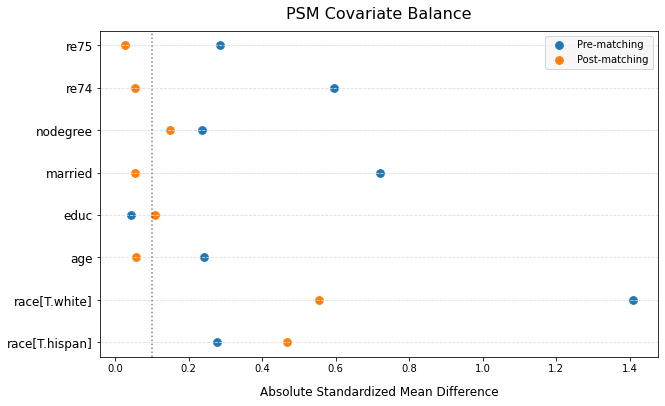

In [36]:
match.love_plot()

As we'd expect, there's much better balance when we sampled with replacement – of course, this decision entails a bias-variance tradeoff that should be considered during subsequent analysis.

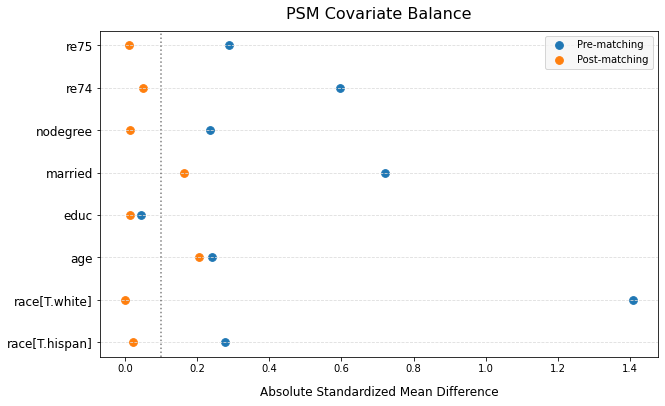

In [37]:
match2.love_plot()